# Download data


In [58]:
# !git clone https://github.com/trongtuyen99/face-recogition

Cloning into 'face-recogition'...
remote: Enumerating objects: 2110, done.
remote: Total 2110 (delta 0), reused 0 (delta 0), pack-reused 2110
Receiving objects: 100% (2110/2110), 213.03 MiB | 35.68 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [0]:
# !cp -R /content/drive/"My Drive"/face_images/* /content/face_images

# Import requirement lib

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
import itertools

# Prepare data, data agumentaion

In [0]:
# thay đổi độ sáng
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    if value>0:
      lim = 255 - value
      v[v > lim] = 255
      v[v <= lim] += value
    if value<0:
      b = -value
      v[v > b] -= b
      v[v <= b] = 0

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [26]:
# load data
import os
import time
import numpy as np
import matplotlib.pyplot as plt
def load_data(path_faces = r"/content/face-recogition/face_images"):
  keep_image = 45
  test = np.random.randn(128, 128) # fixed size
  X = np.array(test.reshape(1, *test.shape))
  Y = []

  for folder in os.listdir(path_faces):
    t1 = time.time()
    print(f"prepare data for folder {folder}")
    f = os.path.join(path_faces, folder)
    n = len(os.listdir(f)) # min(n) = 49
    Y += [str(folder)] * (45 * 10)
    for file in os.listdir(f)[:45]:
      file_path = os.path.join(f, file)

      origin = cv2.imread(file_path)
      # origin = cv2.resize(origin, (128, 128))

      img0 = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # convert to gray scale
      img0 = cv2.resize(img0, (128, 128)) # to make all same size
      #
      img = img0 / 255 #normalize every image
      X = np.concatenate((X, img.reshape(1, *img.shape)))

      # data agumentation
      # add gaussian noise
      img_noise = (img0 + 5*np.random.randn(*img0.shape))/255 
      X = np.concatenate((X, img_noise.reshape(1, *img0.shape)))
      img_noise = (img0 + 10*np.random.randn(*img0.shape))/255 # add gaussian noise
      X = np.concatenate((X, img_noise.reshape(1, *img0.shape)))

      # change brightness
      frame = increase_brightness(origin, value=20) # brighter by 20
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      frame = cv2.resize(frame, (128, 128))
      X = np.concatenate((X, frame.reshape(1, *img.shape)))
      frame = increase_brightness(origin, value=-20) # darker by 20
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      frame = cv2.resize(frame, (128, 128))
      X = np.concatenate((X, frame.reshape(1, *img.shape)))

      # rotate
      w = img.shape[1]
      h = img.shape[0]
      M5 = cv2.getRotationMatrix2D((w/2,h/2), 5, 1) # rotate 5
      image1 = cv2.warpAffine(img, M5,(w,h))
      X = np.concatenate((X, image1.reshape(1, *img.shape)))

      M_5 = cv2.getRotationMatrix2D((w/2,h/2), -5, 1) # rotate -5
      image1 = cv2.warpAffine(img,M_5,(w,h))
      X = np.concatenate((X, image1.reshape(1, *img.shape)))

      M10 = cv2.getRotationMatrix2D((w/2,h/2), 10, 1) # rotate 10
      image1 = cv2.warpAffine(img,M10,(w,h))
      X = np.concatenate((X, image1.reshape(1, *img.shape)))

      M_10 = cv2.getRotationMatrix2D((w/2,h/2), -10, 1) # rotate -10
      image2 = cv2.warpAffine(img,M_10,(w,h))
      X = np.concatenate((X, image2.reshape(1, *img.shape)))
      #flip
      flip = np.fliplr(img) # flip image
      X = np.concatenate((X, flip.reshape(1, *img.shape)))

    print(len(X), len(Y))
    print(f"done folder {folder} after {time.time()-t1} s")
  X = np.array(X)
  Y = np.array(Y)
  return X[1:], Y

X, Y = load_data()

# X: (2035, (128, 128))
# Y: (2035,)

prepare data for folder trung ruoi
451 450
done folder trung ruoi after 4.278392791748047 s
prepare data for folder nguyen nhat anh
901 900
done folder nguyen nhat anh after 12.510040998458862 s
prepare data for folder vinh rau
1351 1350
done folder vinh rau after 20.666158199310303 s
prepare data for folder virus
1801 1800
done folder virus after 28.7215633392334 s
prepare data for folder van dung
2251 2250
done folder van dung after 34.65760588645935 s
prepare data for folder den vau
2701 2700
done folder den vau after 43.50745129585266 s
prepare data for folder dungnv12
3151 3150
done folder dungnv12 after 51.33854103088379 s
prepare data for folder minh tit
3601 3600
done folder minh tit after 58.50646638870239 s
prepare data for folder quynh cool
4051 4050
done folder quynh cool after 66.10508847236633 s
prepare data for folder vanh leg
4501 4500
done folder vanh leg after 74.5618028640747 s
prepare data for folder mac van khoa
4951 4950
done folder mac van khoa after 81.388860940

In [0]:
# encode label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)
import joblib
joblib.dump(le, r"label_encoder_95")

In [0]:
# label = ['11', '189', '204', '230', '244', '274', '4', '434', '459', '462',
#        '478', '482', '509', '572', '576', '594', '660', '666', '680',
#        '720', '731', '760', '777', '827', '94', '959', '994', '997',
#        '998']

In [0]:
# name_folder = {11: "khong ro ten", 
#  189: "pewpew",
#  204: "trung ruoi",
#  230: "vanh leg",
#  244: "quang thang", 
#  274: "dinh la thang ko ro",
#  4: "b girl ko ro", 
#  434: "ms thy", 
#  459: "huynh duc ko ro", 
#  462: "bau duc", 
#  478: "bui tien dung",
#  482: "bui nhat anh",
#  509: "vinh rau", 
#  572: "virus",
#  576: "bac j do",
#  594: "quynh kool",
#  660: "black bi",
#  666: "viet johan",
#  680: "chi xinh gai",
#  720: "minh tit",
#  731: "huynh phuong",
#  760: "nguyen van duc",
#  777: "mac van khoa",
#  827: "phan manh quynh",
#  94: "chi xinh dep",
#  959: "duy manh",
#  994: "chu tich vietjet air",
#  997: "Den vau",
#  998: "van dung"
#  }

In [0]:
# mapping_name = {}
# for i, e in enumerate(label):
#   mapping_name[i] = name_folder[int(e)]
# print(mapping_name)

{0: 'khong ro ten', 1: 'pewpew', 2: 'trung ruoi', 3: 'vanh leg', 4: 'quang thang', 5: 'dinh la thang ko ro', 6: 'b girl ko ro', 7: 'ms thy', 8: 'huynh duc ko ro', 9: 'bau duc', 10: 'bui tien dung', 11: 'bui nhat anh', 12: 'vinh rau', 13: 'virus', 14: 'bac j do', 15: 'quynh kool', 16: 'black bi', 17: 'viet johan', 18: 'chi xinh gai', 19: 'minh tit', 20: 'huynh phuong', 21: 'nguyen van duc', 22: 'mac van khoa', 23: 'phan manh quynh', 24: 'chi xinh dep', 25: 'duy manh', 26: 'chu tich vietjet air', 27: 'Den vau', 28: 'van dung'}


In [0]:
x_train, x_valid, y_train, y_valid= train_test_split(
    X, Y, test_size=.05, random_state=8888,)

# Build model

In [0]:
# buid
#filters= the depth of output image or kernels

batch_size=512
im_shape=(*X[0].shape, 1)

cnn_model= Sequential([
    Conv2D(filters=32, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=48, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.4),
    Dense(1024, activation='relu'),
      Dropout(0.4),
    Dense(512, activation='relu'),
      Dropout(0.4),
    #29 is the number of outputs
    Dense(21, activation='softmax')  
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

In [0]:
x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *im_shape)

In [63]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 122, 122, 32)      1600      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 55, 55, 48)        75312     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 54)        127062    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 54)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5400)             

In [0]:
# Model: "sequential_4" => 0.9174 valid
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_7 (Conv2D)            (None, 122, 122, 36)      1800      
# _________________________________________________________________
# max_pooling2d_7 (MaxPooling2 (None, 61, 61, 36)        0         
# _________________________________________________________________
# conv2d_8 (Conv2D)            (None, 57, 57, 54)        48654     
# _________________________________________________________________
# max_pooling2d_8 (MaxPooling2 (None, 28, 28, 54)        0         
# _________________________________________________________________
# flatten_4 (Flatten)          (None, 42336)             0         
# _________________________________________________________________
# dense_13 (Dense)             (None, 2024)              85690088  
# _________________________________________________________________
# dropout_10 (Dropout)         (None, 2024)              0         
# _________________________________________________________________
# dense_14 (Dense)             (None, 1024)              2073600   
# _________________________________________________________________
# dropout_11 (Dropout)         (None, 1024)              0         
# _________________________________________________________________
# dense_15 (Dense)             (None, 512)               524800    
# _________________________________________________________________
# dropout_12 (Dropout)         (None, 512)               0         
# _________________________________________________________________
# dense_16 (Dense)             (None, 29)                14877     
# =================================================================
# Total params: 88,353,819
# Trainable params: 88,353,819
# Non-trainable params: 0

# Training

In [64]:
history=cnn_model.fit(
    np.array(x_train), np.array(y_train), batch_size=512,
    epochs=90, verbose=2,
    validation_data=(np.array(x_valid),np.array(y_valid)),
)

Train on 8977 samples, validate on 473 samples
Epoch 1/90
 - 5s - loss: 3.4431 - accuracy: 0.0559 - val_loss: 3.0412 - val_accuracy: 0.0655
Epoch 2/90
 - 4s - loss: 3.0360 - accuracy: 0.0801 - val_loss: 3.0297 - val_accuracy: 0.0930
Epoch 3/90
 - 4s - loss: 3.0177 - accuracy: 0.1025 - val_loss: 3.0129 - val_accuracy: 0.0719
Epoch 4/90
 - 4s - loss: 2.9956 - accuracy: 0.1212 - val_loss: 2.9858 - val_accuracy: 0.1163
Epoch 5/90
 - 4s - loss: 2.9670 - accuracy: 0.1498 - val_loss: 2.9474 - val_accuracy: 0.2008
Epoch 6/90
 - 4s - loss: 2.9236 - accuracy: 0.1827 - val_loss: 2.8874 - val_accuracy: 0.3171
Epoch 7/90
 - 4s - loss: 2.8711 - accuracy: 0.2216 - val_loss: 2.8154 - val_accuracy: 0.3214
Epoch 8/90
 - 4s - loss: 2.8198 - accuracy: 0.2526 - val_loss: 2.7872 - val_accuracy: 0.3488
Epoch 9/90
 - 4s - loss: 2.7698 - accuracy: 0.2832 - val_loss: 2.7567 - val_accuracy: 0.3573
Epoch 10/90
 - 4s - loss: 2.7168 - accuracy: 0.2844 - val_loss: 2.6762 - val_accuracy: 0.2685
Epoch 11/90
 - 4s - lo

# Visualize result

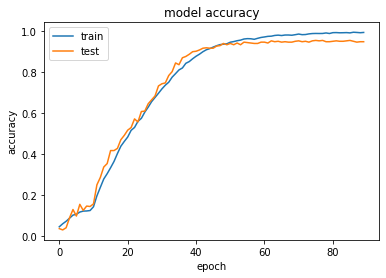

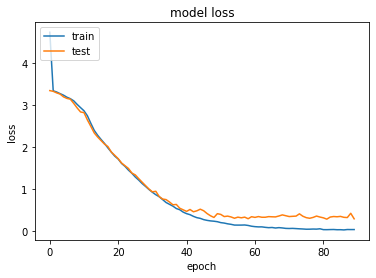

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save and load model

In [42]:
from keras.models import model_from_json
model_json = cnn_model.to_json()
with open("/content/drive/My Drive/model_95.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_model.save_weights("/content/drive/My Drive/model_95.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('/content/drive/My Drive/model_95.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/model_95.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
score = loaded_model.evaluate(x_valid[:], y_valid[:], verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Saved model to disk
Loaded model from disk
accuracy: 94.71%


In [50]:
!zip model_95_all.zip "/content/drive/My Drive/label_encoder_95" "/content/drive/My Drive/model_95.h5" "/content/drive/My Drive/model_95.json"

  adding: content/drive/My Drive/label_encoder_95 (deflated 76%)
  adding: content/drive/My Drive/model_95.h5 (deflated 8%)
  adding: content/drive/My Drive/model_95.json (deflated 89%)


In [47]:
le.classes_

array(['black bi', 'bui tien dung', 'den vau', 'dungnv12', 'duy manh',
       'huynh phuong', 'mac van khoa', 'minh tit', 'miss thy',
       'nguyen nhat anh', 'nguyen thi phuong thao', 'pew pew',
       'phan manh quynh', 'quang thang', 'quynh cool', 'trung ruoi',
       'van dung', 'vanh leg', 'viet johan', 'vinh rau', 'virus'],
      dtype='<U22')